In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score 
import pymc as pm
import arviz as az

In [3]:
base_path = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/yso_study_simulation/'
df_test = pd.read_csv(base_path + 'simulated_data/sim_field_clusters_TrainTest_sagitta_pmsClf.csv')

In [48]:
df_test_old = pd.read_csv('/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/yso_study_simulation/simulated_data/mock_solar_nbh_test_set_predictions.csv')

In [50]:
cols2match = ['age_est_sagitta',
       'age_mean_sagitta', 'age_median_sagitta', 'age_std_sagitta',
       'age_min_sagitta', 'age_max_sagitta', 'logAge_pred_test_data_SEDonly',
       'logAge_pred_std_test_data_SEDonly', 'dist_pred_test_data_SEDonly',
       'logAge_pred_test_data_allFeatures',
       'logAge_pred_std_test_data_allFeatures',
       'dist_pred_test_data_allFeatures', 'logAge_pred_test_data_Sagitta',
       'logAge_pred_std_test_data_Sagitta', 'dist_pred_test_data_Sagitta',
       'dist_pred_std_test_data_SEDonly', 'dist_pred_std_test_data_Sagitta',
       'dist_pred_std_test_data_allFeatures']
df_test[cols2match] = df_test_old[cols2match]

In [4]:
df_test['distance_true'] = 1000/df_test['parallax_true']
df_test['distance_obs'] = 1000/df_test['parallax_obs']

In [4]:
# cut_range = df_test.logAge <= 9
# 
# pred_values = [col for col in df_test.columns if 'logAge_pred_test_' in col] + ['age_mean_sagitta']
# # pred_values = [col for col in df_test.columns if 'dist_pred_test_data' in col] + ['distance_obs']
# x_true = 'logAge'
# 
# for x_pred in pred_values: 
#     r2 = r2_score(df_test.loc[cut_range, x_true], df_test.loc[cut_range, x_pred])
#     print(f'{x_pred}: {r2:.2f}')

In [5]:
pred_values = [col for col in df_test.columns if 'logAge_pred_test_' in col] + ['age_mean_sagitta']

avg_uncertainty = {x_pred: [] for x_pred in pred_values}
dx = 100
x_bins = np.arange(0, 1000, dx)
x_true = 'distance_true'

for x_pred in pred_values: 
    for bin in x_bins:
        cut_range = (df_test[x_true] > bin) & (df_test[x_true] < bin + dx)
        # dev_measure = np.std(df_test.loc[cut_range, x_true] - df_test.loc[cut_range, x_pred])
        dev_measure = np.median(np.abs(df_test.loc[cut_range, x_true] - df_test.loc[cut_range, x_pred]))
        avg_uncertainty[x_pred].append(dev_measure)

# Bootstrap linear model predictions

In [6]:
pred_values = [col for col in df_test.columns if 'dist_pred_test_data' in col] + ['distance_obs']

In [7]:
# Fit linear model to data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.pipeline import make_pipeline

x_true = 'distance_true'
x_vals = np.linspace(0, 1000, 500)
lr_predictions = {x_pred: [] for x_pred in pred_values} 

n_bootstrap = 100
# n_bootstrap = 1000
for x_pred in pred_values: 
    for _ in range(n_bootstrap):
        rand_subset = np.random.choice(df_test.index, size=1000, replace=True)
        x = df_test.loc[rand_subset, x_true].values.reshape(-1, 1)
        y = np.abs(df_test.loc[rand_subset, x_pred].values - df_test.loc[rand_subset, x_true].values) 
        model = make_pipeline(PolynomialFeatures(2), HuberRegressor()).fit(x, y)
        y_pred = model.predict(x_vals.reshape(-1, 1))
        lr_predictions[x_pred].append(y_pred)

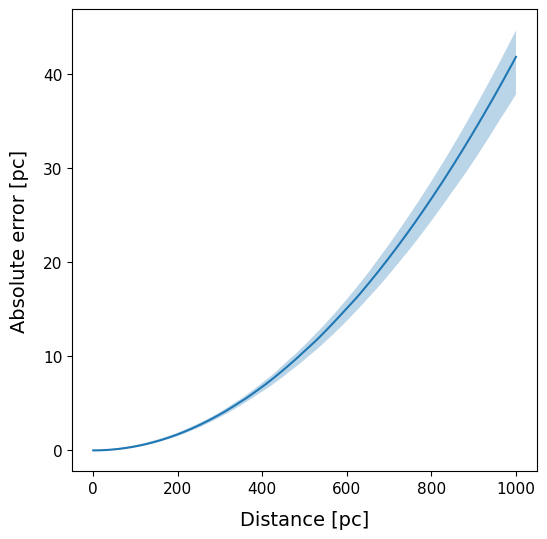

In [8]:
# Average linear model predictions and plot 1 sigma uncertainty band
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for x_pred in pred_values: 
    y_pred = np.array(lr_predictions[x_pred])
    # y_pred_mean = np.mean(y_pred, axis=0)
    y_pred_lo, y_pred_mean, y_pred_hi = np.percentile(y_pred, [16, 50, 84], axis=0)
    ax.plot(x_vals, y_pred_mean, label=x_pred)
    ax.fill_between(x_vals, y_pred_lo, y_pred_hi, alpha=0.3)
    
ax.set_xlabel('Distance [pc]', fontsize=14, labelpad=10)
ax.set_ylabel('Absolute error [pc]', fontsize=14, labelpad=10)
# Tick size
ax.tick_params(axis='both', which='major', labelsize=11)

# plt.legend(frameon=False)
# plt.savefig('/Users/ratzenboe/Desktop/figures/new/uncertainty_vs_distance.png', dpi=300, bbox_inches='tight')

# ROC curve

In [51]:
# Compute contamination and completeness from confusion matrix
th_true = 7.78

def compute_completenes_contaminiation(age_pred, age_true, th, th_true=7.78):
    # True positive: YSOs with age < th
    # False positive: BG with age < th
    # True negative: BG with age >= th
    # False negative: YSOs with age >= th
    true_positive = np.sum((age_pred<th) & (age_true<th_true))
    false_positive = np.sum((age_pred<th) & (age_true>th_true))
    true_negative = np.sum((age_pred>th) & (age_true>th_true))
    false_negative = np.sum((age_pred>th) & (age_true<th_true))
    # Compute completeness and contamination
    # Completeness = TP / (TP + FN) ... also true positive rate, recall, or sensitivity
    completeness = true_positive / (true_positive + false_negative)
    # Contamination = FP / (TP + FP)
    contamination = false_positive / (true_positive + false_positive)
    # FP / (FP + TN) ... also false positive rate
    fpr = false_positive / (false_positive + true_negative)
    return completeness, contamination, fpr


# Compute ROC curve by varying the threshold
def compute_roc_curve(age_pred, age_true, th_range, th_true=7.78):
    tpr_all = []
    fpr_all = []
    for th in th_range:
        tpr, _, fpr = compute_completenes_contaminiation(age_pred, age_true, th, th_true=th_true)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    return np.array(tpr_all), np.array(fpr_all)

In [61]:
def ccc_sagitta(pms_est, age_true, th, th_true=7.78):
    # True positive: YSOs with age < th
    # False positive: BG with age < th
    # True negative: BG with age >= th
    # False negative: YSOs with age >= th
    true_positive = np.sum((pms_est>=th) & (age_true<th_true))
    false_positive = np.sum((pms_est>=th) & (age_true>th_true))
    true_negative = np.sum((pms_est<=th) & (age_true>th_true))
    false_negative = np.sum((pms_est<=th) & (age_true<th_true))
    # Compute completeness and contamination
    # Completeness = TP / (TP + FN) ... also true positive rate, recall, or sensitivity
    completeness = true_positive / (true_positive + false_negative)
    # Contamination = FP / (TP + FP)
    contamination = false_positive / (true_positive + false_positive)
    # FP / (FP + TN) ... also false positive rate
    fpr = false_positive / (false_positive + true_negative)
    return completeness, contamination, fpr

def roc_sagitta(pms_est, age_true, th_range, th_true=7.78):
    tpr_all = []
    fpr_all = []
    for th in th_range:
        tpr, _, fpr = ccc_sagitta(pms_est, age_true, th, th_true=th_true)
        tpr_all.append(tpr)
        fpr_all.append(fpr)
    return np.array(tpr_all), np.array(fpr_all)

In [95]:
ccc_sagitta(df_test.pms_est_sagitta.values, df_test.logAge.values, th=0.5, th_true=7.78)

(0.7992694063926941, 0.16320871976288365, 0.08960629921259843)

In [81]:
th_range_sagitta = np.linspace(0, 1, 100)
tpr_sagitta, fpr_sagitta = roc_sagitta(df_test.pms_est_sagitta, df_test.logAge, th_range_sagitta)

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_46960/1883721767.py:14: RuntimeWarning: invalid value encountered in scalar divide
  contamination = false_positive / (true_positive + false_positive)


In [82]:
# _, bins, _ = plt.hist(df_test.loc[df_test.logAge < 7.787878, 'pms_est_sagitta'], bins=100, histtype='step', color='tab:blue', log=True)
# plt.hist(df_test.loc[df_test.logAge >= 7.787878, 'pms_est_sagitta'], bins=bins, histtype='step', color='tab:orange', log=True)

In [83]:
pred_values = [col for col in df_test.columns if 'logAge_pred_test_' in col] 

In [87]:
np.argmin(np.abs(th_range_sagitta - 0.5))

49

logAge_pred_test_data_SEDonly [0.08918635] [0.92136986]
logAge_pred_test_data_allFeatures [0.03506562] [0.95488584]
logAge_pred_test_data_Sagitta [0.02824147] [0.94511416]


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_46960/898579534.py:17: RuntimeWarning: invalid value encountered in scalar divide
  contamination = false_positive / (true_positive + false_positive)


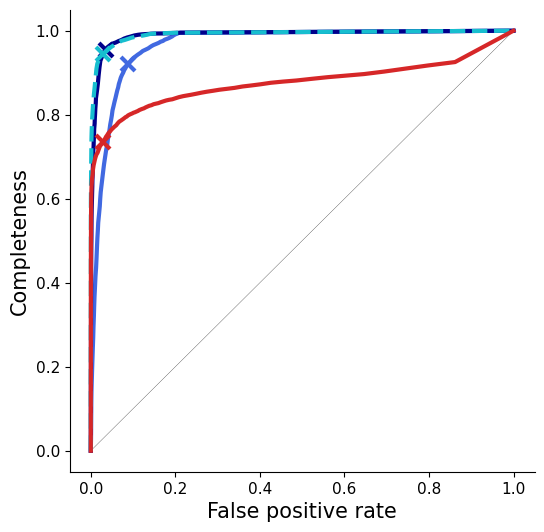

In [98]:
# Average linear model predictions and plot 1 sigma uncertainty band
th_range = np.linspace(6.0, 9., 100)
x_true = 'logAge'
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.plot([0, 1], [0, 1], color='k', ls='-', lw=0.2)

colors = ['royalblue', 'darkblue',  'tab:cyan',  'tab:red'] #, 'tab:purple', 'tab:pink', 'tab:cyan]

for x_pred, col in zip(pred_values, colors): 
    tpr_sbi, fpr_sbi = compute_roc_curve(
        df_test[x_pred], df_test[x_true], th_range, th_true=th_true,
    )
    if 'data_Sagitta' in x_pred:
        ls = '--'
    else:
        ls = '-'
    ax.plot(fpr_sbi.tolist() + [1], tpr_sbi.tolist() + [1], label=x_pred, c=col, lw=3, ls=ls)
    ax.plot(
        fpr_sbi[np.isclose(th_range, 7.78787879)], tpr_sbi[np.isclose(th_range, 7.78787879)],
        ms=10, marker='x', mew=3, ls="none", mec=col, 
    )
    print(x_pred, fpr_sbi[np.isclose(th_range, 7.78787879)], tpr_sbi[np.isclose(th_range, 7.78787879)])


ax.plot(fpr_sagitta.tolist(), tpr_sagitta.tolist(), label=x_pred, c='tab:red', lw=3, ls='-')
colsest_to_05 = np.argmin(np.abs(fpr_sagitta - 0.028))
# ax.plot(
#     fpr_sagitta[colsest_to_05], tpr_sagitta[colsest_to_05],
#     ms=10, marker='x', mew=3, ls="none", mec='tab:red', 
# )

    
plt.xlabel('False positive rate', size=15)
plt.ylabel('Completeness', size=15)
# Tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(frameon=False, fontsize=15)
# plt.gca().set_aspect('equal', adjustable='box')
# Tick size
ax.tick_params(axis='both', which='major', labelsize=11)
# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.legend(frameon=False)
# plt.savefig('/Users/ratzenboe/Desktop/figures/new/ROC_sagitta.png', dpi=300, bbox_inches='tight')

In [100]:
tpr_sagitta[colsest_to_05]

0.7357077625570776

In [101]:
def compute_tp(age_pred, age_true, th, th_true=7.78):
    true_positive = np.sum((age_pred<th) & (age_true<th_true))
    false_positive = np.sum((age_pred<th) & (age_true>th_true))
    true_negative = np.sum((age_pred>th) & (age_true>th_true))
    false_negative = np.sum((age_pred>th) & (age_true<th_true))
    # Compute completeness and contamination
    # Completeness = TP / (TP + FN) ... also true positive rate, recall, or sensitivity
    completeness = true_positive / (true_positive + false_negative)
    # Contamination = FP / (TP + FP)
    contamination = false_positive / (true_positive + false_positive)
    # FP / (FP + TN) ... also false positive rate
    fpr = false_positive / (false_positive + true_negative)
    return true_positive, fpr

def compute_all_tps(age_pred, age_true, th_range, th_true=7.78):
    tps_all = []
    fpr_all = []
    for th in th_range:
        tp, fpr = compute_tp(age_pred, age_true, th, th_true=th_true)
        tps_all.append(tp)
        fpr_all.append(fpr)
    return np.array(tps_all), np.array(fpr_all)

In [121]:
def tp_sagitta(pms_est, age_true, th, th_true=7.78):
    # True positive: YSOs with age < th
    # False positive: BG with age < th
    # True negative: BG with age >= th
    # False negative: YSOs with age >= th
    true_positive = np.sum((pms_est>=th) & (age_true<th_true))
    false_positive = np.sum((pms_est>=th) & (age_true>th_true))
    true_negative = np.sum((pms_est<=th) & (age_true>th_true))
    false_negative = np.sum((pms_est<=th) & (age_true<th_true))
    # Compute completeness and contamination
    # Completeness = TP / (TP + FN) ... also true positive rate, recall, or sensitivity
    completeness = true_positive / (true_positive + false_negative)
    # Contamination = FP / (TP + FP)
    contamination = false_positive / (true_positive + false_positive)
    # FP / (FP + TN) ... also false positive rate
    fpr = false_positive / (false_positive + true_negative)
    return true_positive, fpr

def compute_all_tps_sagitta(pms_est, age_true, th_range, th_true=7.78):
    tpr_all = []
    fpr_all = []
    for th in th_range:
        tp, fpr = tp_sagitta(pms_est, age_true, th, th_true=th_true)
        tpr_all.append(tp)
        fpr_all.append(fpr)
    return np.array(tpr_all), np.array(fpr_all)

In [108]:
pred_values = ['logAge_pred_test_data_Sagitta']

In [109]:
# pred_values = [col for col in df_test.columns if 'logAge_pred_test_' in col] + ['age_mean_sagitta']
# pred_values

In [110]:
th_range = np.linspace(6.0, 9., 100)
x_true = 'logAge'
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plt.plot([0, 1], [0, 1], color='k', ls='-', lw=0.2)

colors = ['tab:blue', 'tab:green',  'tab:orange',  'tab:pink'] #, 'tab:purple', 'tab:pink', 'tab:cyan]

info_all = {x_pred: {} for x_pred in pred_values}

for x_pred, col in zip(pred_values, colors): 
    tp_abs, fpr_abs = compute_all_tps(
        df_test[x_pred], df_test[x_true], th_range, th_true=th_true,
    )
    info_all[x_pred]['tp'] = tp_abs
    info_all[x_pred]['fpr'] = fpr_abs

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_46960/2635876189.py:10: RuntimeWarning: invalid value encountered in scalar divide
  contamination = false_positive / (true_positive + false_positive)


In [122]:
th_range_sagitta = np.linspace(0, 1, 200)
tp_sagitta, fpr_sagitta = compute_all_tps_sagitta(
    df_test.pms_est_sagitta, df_test.logAge, th_range_sagitta
)

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_46960/56309222.py:14: RuntimeWarning: invalid value encountered in scalar divide
  contamination = false_positive / (true_positive + false_positive)


In [132]:
info_all['logAge_pred_test_data_Sagitta']['tp'][np.argmin(np.abs(info_all['logAge_pred_test_data_Sagitta']['fpr'] - 0.003))]

8625

In [134]:
np.sum((df_test.labels>-1) & (df_test.logAge < 7.78))

10872

In [133]:
tp_sagitta[np.argmin(np.abs(fpr_sagitta - 0.003))]

7065

In [129]:
8343/6901

1.208955223880597

In [540]:
x_pred = 'logAge_pred_test_data_Sagitta'

for fpr in np.linspace(0, 10/100, 11):
    sag_n_true = info_all['age_mean_sagitta']['tp'][np.argmin(np.abs(info_all['age_mean_sagitta']['fpr'] - fpr))]
    ours_n_true = info_all[x_pred]['tp'][np.argmin(np.abs(info_all[x_pred]['fpr'] - fpr))]
    
    print(fpr*100, ours_n_true, sag_n_true)

0.0 0 6
1.0 9577 367
2.0 10220 905
3.0 10349 1271
4.0 10437 1536
5.0 10533 2146
6.0 10612 2498
7.000000000000001 10687 2852
8.0 10711 2852
9.0 10740 3219
10.0 10770 3590


In [483]:
info_all['age_mean_sagitta']['fpr']

array([0.00225722, 0.00267717, 0.00288714, 0.00309711, 0.0032021 ,
       0.00372703, 0.0039895 , 0.00430446, 0.00472441, 0.00524934,
       0.0055643 , 0.00619423, 0.00698163, 0.00755906, 0.00855643,
       0.00939633, 0.01065617, 0.0128084 , 0.01532808, 0.01874016,
       0.02325459, 0.02971129, 0.03622047, 0.04425197, 0.05417323,
       0.0632021 , 0.07354331, 0.0871916 , 0.10204724, 0.1184252 ,
       0.13606299, 0.1551706 , 0.1760105 , 0.19895013, 0.22908136,
       0.26771654, 0.31427822, 0.36047244, 0.39779528, 0.43107612,
       0.46440945, 0.49853018, 0.5351706 , 0.57265092, 0.60986877,
       0.64813648, 0.69254593, 0.74771654, 0.80314961, 0.86188976,
       0.9135958 , 0.95102362, 0.97816273, 0.99217848, 0.99790026,
       0.99937008, 0.99984252, 0.99994751, 0.99994751, 0.99994751,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

# Compute XY plots

In [23]:
# Construct coolwarm color map with transition at given threshold
import matplotlib

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    matplotlib.colormaps.register(cmap=newcmap)
    return newcmap

orig_cmap = matplotlib.cm.coolwarm

min_age, max_age = 6.2, 9
transition_age = 7.78
midpoint = (transition_age - min_age) / (max_age - min_age)
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted_coolwarm_60_6p2')

In [24]:
pred_values_logAge = [col for col in df_test.columns if 'logAge_pred_test_' in col] + ['age_mean_sagitta']
pred_values_dist = [col for col in df_test.columns if 'dist_pred_test_data' in col] + ['distance_obs']

In [25]:
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astropy import units as u

def compute_xyz_pred(X_obs, Y_obs, Z_obs, dist_pred):
    # Compute predicted X,Y,Z positions
    c_gal = SkyCoord(
        u=X_obs*u.pc,
        v=Y_obs*u.pc,
        w=Z_obs * u.pc,
        frame='galactic',
        representation_type='cartesian'
    )
    c_icrs = c_gal.transform_to(ICRS())
    c_icrs.representation_type = 'spherical'
    
    c = SkyCoord(ra=c_icrs.ra.value*u.deg, dec=c_icrs.dec.value*u.deg, distance=dist_pred * u.pc, frame='icrs')
    c = c.transform_to(Galactic())
    c.representation_type = 'cartesian'
    X_pred = c.u.value
    Y_pred = c.v.value
    Z_pred = c.w.value
    
    return X_pred, Y_pred, Z_pred

In [13]:
cut_subset = np.load('cut_subset.npy')

In [14]:
# Show only a subset of clusters, otherwise the plot becomes very crowded
# n_plt_clusters = 20
# labels_unique, count_unique = np.unique(df_test.loc[df_test.labels>-1, 'labels'], return_counts=True)
# # random_subset_clusters = np.random.choice(labels_unique, n_plt_clusters, replace=False)
# cut_subset = df_test.labels.isin(random_subset_clusters.tolist() + [-1, 106]) #, 176]) #, 167, 176])
df_plt = df_test.loc[cut_subset]

(-1000.0, 1000.0)

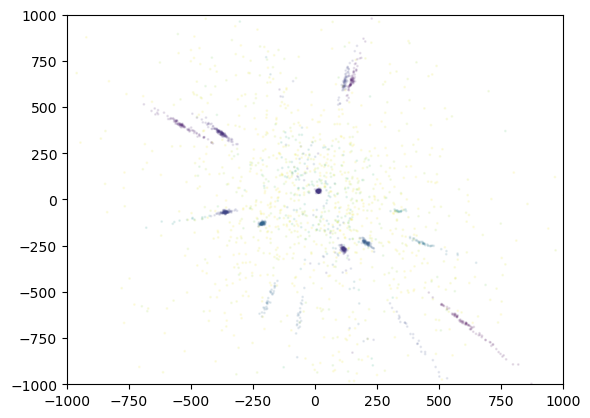

In [19]:
cut_sagitta_pms = df_plt.pms_est_sagitta > 0.5

plt.scatter(df_plt.loc[cut_sagitta_pms, 'X_obs'], df_plt.loc[cut_sagitta_pms, 'Y_obs'], s=1, alpha=0.1, c=df_plt.loc[cut_sagitta_pms, 'logAge'])
plt.ylim(-1000, 1000)
plt.xlim(-1000, 1000)

In [26]:
pred_values_logAge = [
    # 'logAge',
    # 'logAge',
    'age_mean_sagitta',
    # 'logAge_pred_test_data_Sagitta',
    # 'logAge_pred_test_data_SEDonly',
    # 'logAge_pred_test_data_allFeatures',
]

pred_values_dist = [
    # 'distance_true',
    # 'distance_true',
    'distance_obs',
    # 'dist_pred_test_data_Sagitta',
    # 'dist_pred_test_data_SEDonly',
    # 'dist_pred_test_data_allFeatures',
]

In [27]:
# np.save('cut_subset.npy', cut_subset.values)

0


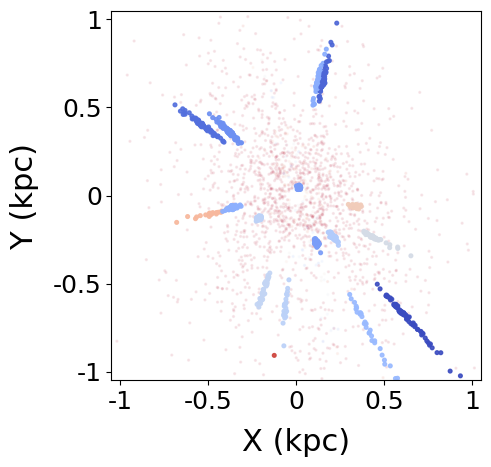

In [33]:
# XY plots
label_kwargs = dict(fontsize=22, labelpad=10)
tick_kwargs = dict(ticks=[-1000, -500, 0, 500, 1000], labels=[-1, -0.5, 0, 0.5, 1], fontsize=18)
bg_kwargs = dict(s=2, alpha=0.07)
sig_kwargs = dict(s=7, alpha=0.9)
xlabel = 'X (kpc)'
ylabel = 'Y (kpc)'

lim = 1050
th_lA = 7.78
equal_aspect = True
fig, axes = plt.subplots(1, len(pred_values_dist), figsize=(len(pred_values_dist)*5, 5), sharex=False, sharey=True) #, =0.1, wspace=0.1)

for i, (logAge_pred, dist_pred) in enumerate(zip(pred_values_logAge, pred_values_dist)):
    print(i)
    if dist_pred == 'distance_true':
        X_pred, Y_pred, Z_pred = df_plt['X'].values, df_plt['Y'].values, df_plt['Z'].values
    elif dist_pred == 'distance_obs':
        X_pred, Y_pred, Z_pred = df_plt['X_obs'].values, df_plt['Y_obs'].values, df_plt['Z_obs'].values
    else:
        # Compute predicted X,Y,Z positions   
        X_pred, Y_pred, Z_pred = compute_xyz_pred(
            df_plt['X_obs'].values, df_plt['Y_obs'].values, df_plt['Z_obs'].values, df_plt[dist_pred].values
        )
    
    plt.subplot(1, len(pred_values_dist), i+1)
    if i == 0:
        cut_bg = (df_plt.labels==-1) & (df_plt.pms_est_sagitta > 0.4) 
        cut_sig = (df_plt.labels!=-1) & (df_plt.pms_est_sagitta > 0.4)
    else:
        cut_bg = (df_plt.labels!=-1) & (df_plt[logAge_pred]<th_lA) 
        cut_sig = (df_plt.labels!=-1) & (df_plt[logAge_pred]<th_lA)
        
    
    plt.scatter(
        X_pred[cut_bg], Y_pred[cut_bg],
        cmap=shifted_cmap, c=df_plt.loc[cut_bg, 'logAge'], vmin=min_age, vmax=max_age,
        **bg_kwargs
        #c='tab:grey'
    )
    plt.scatter(
        X_pred[cut_sig], Y_pred[cut_sig],
        cmap=shifted_cmap, c=df_plt.loc[cut_sig, 'logAge'], vmin=min_age, vmax=max_age,
        **sig_kwargs
    )
    if i == 0:
        plt.xlabel(xlabel, **label_kwargs)
        plt.ylabel(ylabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True
        )
        plt.yticks(**tick_kwargs)
        plt.xticks(**tick_kwargs)
    else:
        plt.xlabel(xlabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=True, top=False, left=False, right=False, labelbottom=True, labelleft=False
        )
        plt.xticks(**tick_kwargs)
               
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    # plt.title('Observed positions', fontsize=15)
    if equal_aspect:
        plt.gca().set_aspect('equal', adjustable='box')


# cbar_ax = fig.add_axes([0.125, -0.12, 0.78, 0.05])
# cbar = plt.colorbar(cax=cbar_ax, orientation="horizontal", ticks=[6.5, 7, 7.5, 8., 8.5, 9]) #, size=15) #, fontsize=15)
# cbar.ax.tick_params(labelsize=18)
# cbar.set_label(label='log(Age)', size=22, labelpad=10)
# cbar.solids.set(alpha=1)

plt.tight_layout(w_pad=-2.5, h_pad=.5)
plt.savefig('/Users/ratzenboe/Desktop/figures/new/Fig-1_SagittaNEW.png', dpi=300, bbox_inches='tight')

In [ ]:
df_plt = df_test.loc[(df_test.labels!=-1) & df_test.logAge<7.78]
X_pred, Y_pred = df_plt['X'].values, df_plt['Y'].values

plt.scatter(X_pred, )

0
1
2
3
4


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_45179/3337855925.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.1, h_pad=-30)


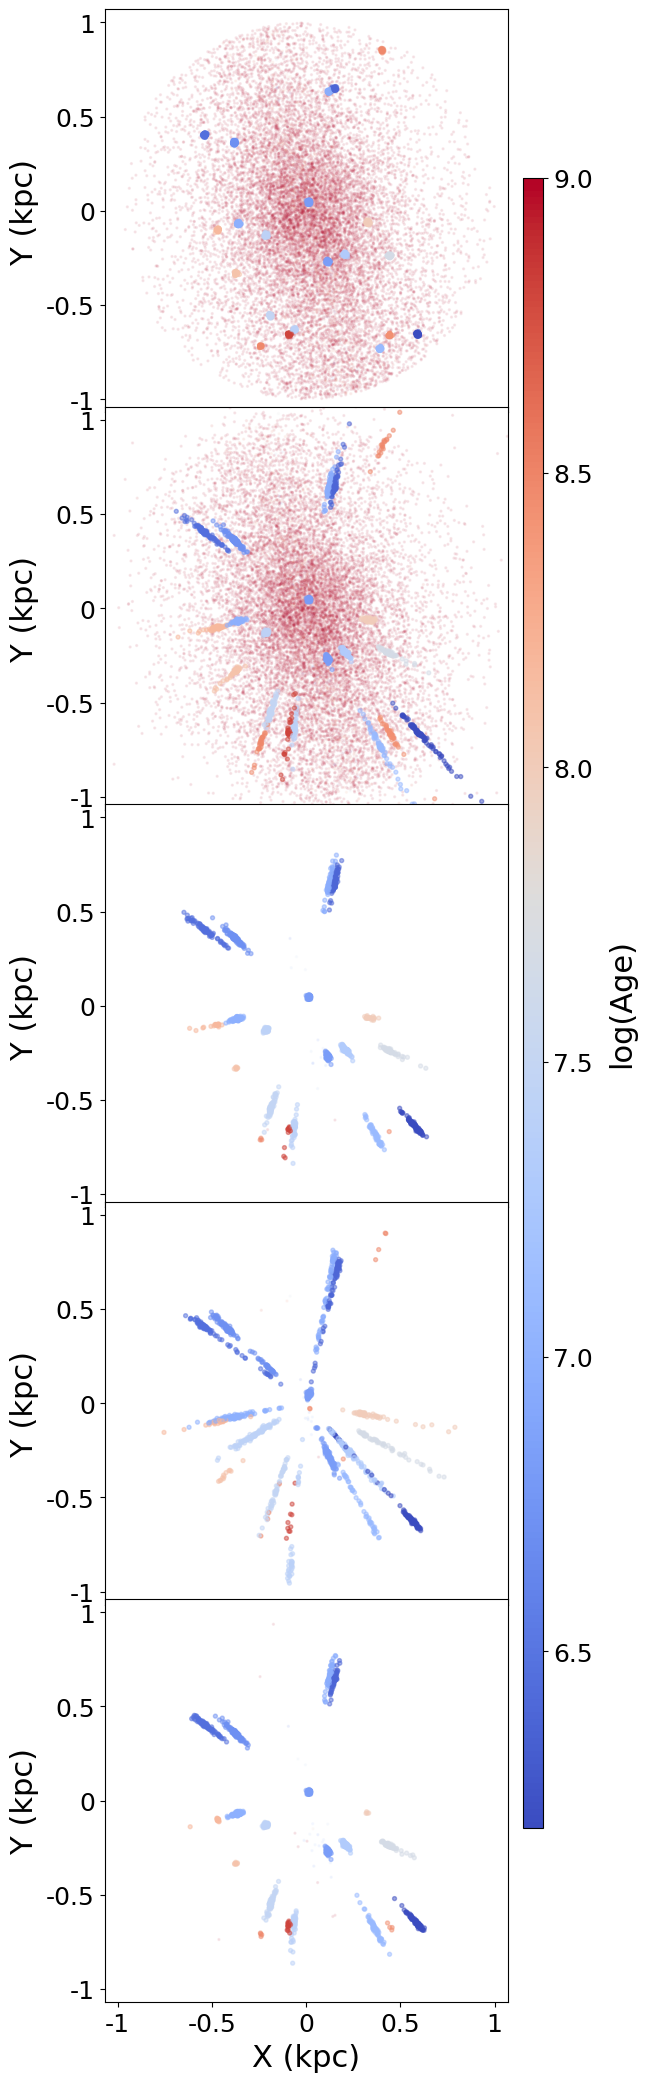

In [309]:
# XY plots
label_kwargs = dict(fontsize=22, labelpad=5)
tick_kwargs = dict(ticks=[-1000, -500, 0, 500, 1000], labels=[-1, -0.5, 0, 0.5, 1], fontsize=18)
bg_kwargs = dict(s=2, alpha=0.07)
sig_kwargs = dict(s=8, alpha=0.5)
xlabel = 'X (kpc)'
ylabel = 'Y (kpc)'

lim = 1070
th_lA = 7.78
equal_aspect = True
fig, axes = plt.subplots(len(pred_values_dist), 1, figsize=(5, len(pred_values_dist)*5), sharex=True, sharey=False) #, =0.1, wspace=0.1)

for i, (logAge_pred, dist_pred) in enumerate(zip(pred_values_logAge, pred_values_dist)):
    if dist_pred == 'distance_true':
        X_pred, Y_pred, Z_pred = df_plt['X'].values, df_plt['Y'].values, df_plt['Z'].values
    elif dist_pred == 'distance_obs':
        X_pred, Y_pred, Z_pred = df_plt['X_obs'].values, df_plt['Y_obs'].values, df_plt['Z_obs'].values
    else:
        # Compute predicted X,Y,Z positions   
        X_pred, Y_pred, Z_pred = compute_xyz_pred(
            df_plt['X_obs'].values, df_plt['Y_obs'].values, df_plt['Z_obs'].values, df_plt[dist_pred].values
        )
    
    plt.subplot(len(pred_values_dist), 1, i+1)
    if i == 0:
        cut_bg = df_plt.labels==-1 
        cut_sig = df_plt.labels!=-1
    else:
        cut_bg = (df_plt.labels==-1) & (df_plt[logAge_pred]<th_lA) 
        cut_sig = (df_plt.labels!=-1) & (df_plt[logAge_pred]<th_lA)
        
    
    plt.scatter(
        X_pred[cut_bg], Y_pred[cut_bg],
        cmap=shifted_cmap, c=df_plt.loc[cut_bg, 'logAge'], vmin=min_age, vmax=max_age,
        **bg_kwargs
        #c='tab:grey'
    )
    plt.scatter(
        X_pred[cut_sig], Y_pred[cut_sig],
        cmap=shifted_cmap, c=df_plt.loc[cut_sig, 'logAge'], vmin=min_age, vmax=max_age,
        **sig_kwargs
    )
    if i == 4:
        plt.xlabel(xlabel, **label_kwargs)
        plt.ylabel(ylabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True
        )
        plt.yticks(**tick_kwargs)
        plt.xticks(**tick_kwargs)
    else:
        plt.ylabel(ylabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True
        )
        plt.yticks(**tick_kwargs)
               
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    # plt.title('Observed positions', fontsize=15)
    if equal_aspect:
        plt.gca().set_aspect('equal', adjustable='box')


cbar_ax = fig.add_axes([1.001, 0.185, 0.04, 0.66])
cbar = plt.colorbar(cax=cbar_ax, orientation="vertical", ticks=[6.5, 7, 7.5, 8., 8.5, 9]) #, size=15) #, fontsize=15)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='log(Age)', size=22, labelpad=10)
cbar.solids.set(alpha=1)

plt.tight_layout(w_pad=0.1, h_pad=-30)
plt.savefig('/Users/ratzenboe/Desktop/figures/new/Fig-1_new_vert.png', dpi=300, bbox_inches='tight')

# LogAge vs pred logAge

In [317]:
from scipy.signal import savgol_filter

def mode_reals(array, bins=100):
    counts, bin_edges = np.histogram(array, bins=bins)
    # Take left edges as approximation for bin midpoint
    bins_left_edges = bin_edges[:-1]
    return bins_left_edges[np.argmax(counts)]

In [310]:
df_plt = df_test.copy()

In [314]:
pred_values_logAge = [
    'age_mean_sagitta',
    'logAge_pred_test_data_Sagitta',
    'logAge_pred_test_data_SEDonly',
    'logAge_pred_test_data_allFeatures'
]

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_45179/2518721004.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(pred_values_dist), i+1)


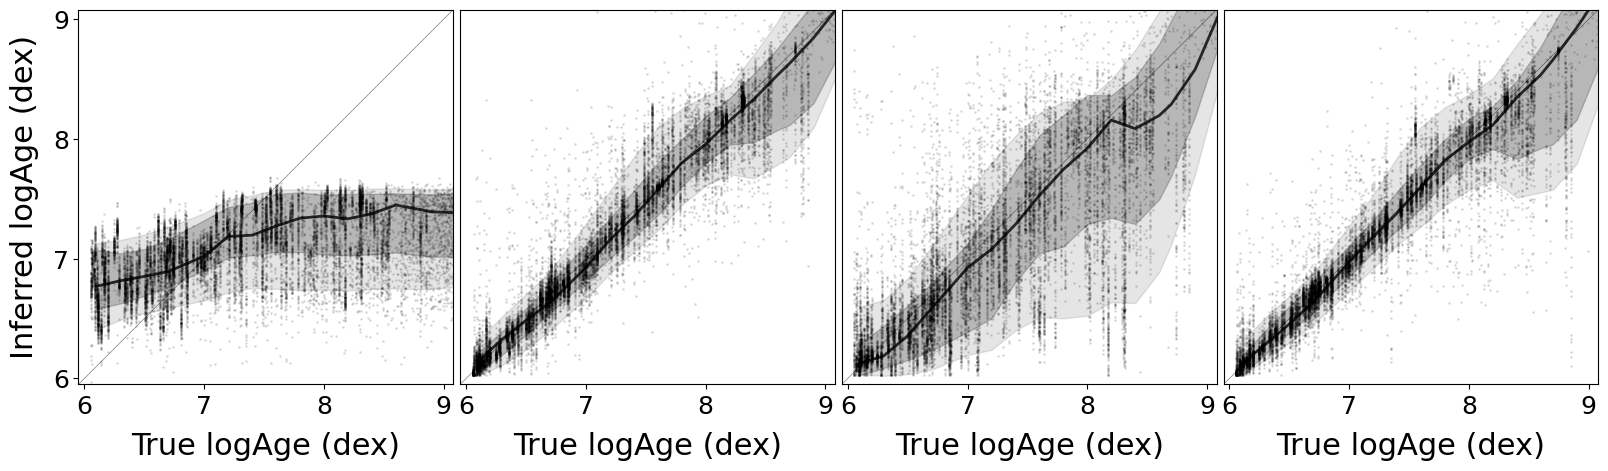

In [451]:
label_kwargs = dict(fontsize=22, labelpad=10)
xtick_kwargs = dict(ticks=[6, 7, 8, 9], fontsize=18)
ytick_kwargs = dict(ticks=[6, 7, 8, 9, 10], fontsize=18)
scatter_kwargs = dict(s=1, alpha=0.1, c='k')
one_one_line_kwargs = dict(color='k', ls='-', lw=0.5, alpha=0.5)
line_kwargs = dict(color='k', ls='-', lw=2, alpha=0.8)
err_band_1s_kwargs = dict(alpha=0.2, color='k')
err_band_2s_kwargs = dict(alpha=0.1, color='k')
filter_kwargs = dict(window_length=8, polyorder=3)

xlabel = 'True logAge (dex)'
ylabel = 'Inferred logAge (dex)'

lims = 5.95, 9.08
th_lA = 7.78
equal_aspect = True
x_true = 'logAge'
# Bins
bin_width = 0.2
bins = np.arange(6, 9.6, bin_width)
lA_max = 9.6

fig, axes = plt.subplots(1, len(pred_values_logAge), figsize=(len(pred_values_logAge)*5, 5), sharex=False, sharey=True)

for i, logAge_pred in enumerate(pred_values_logAge):
    df_plt = df_test.loc[(df_test[x_true] < lA_max) & (df_test[logAge_pred] < lA_max)].copy()
    
    plt.subplot(1, len(pred_values_dist), i+1)
    plt.scatter(
        df_test[x_true], df_test[logAge_pred],
        **scatter_kwargs
    )
    plt.plot(lims, lims, **one_one_line_kwargs)
    
    # Plot confidence intervals
    for hdi_prob, eb_kwargs in zip([0.68, 0.9], [err_band_1s_kwargs, err_band_2s_kwargs]):
        lo_est, mode_est, hi_est, bin_x = [], [], [], []
        for j, bin in enumerate(bins[:-1]):    
            cut_bin = (df_plt[x_true] > bin) & (df_plt[x_true] <= bins[j+1])
            if np.sum(cut_bin) == 0:
                continue
            data_bin = df_plt.loc[cut_bin, logAge_pred].values
            # mode_est.append(np.median(data_bin)) # bins=100))
            if i == 2:
                # mode_est.append(np.median(data_bin)) # bins=100))
                mode_est.append(mode_reals(data_bin, bins=200))
            else:
                mode_est.append(mode_reals(data_bin, bins=100))
            lo, hi = pm.stats.hdi(data_bin, hdi_prob=hdi_prob)
            lo_est.append(lo)
            hi_est.append(hi)
            bin_x.append(bin)
        
        # Smooth curves
        x_vals = savgol_filter(np.array(bin_x) + bin_width/2, **filter_kwargs)
        lo_est = savgol_filter(lo_est, **filter_kwargs)
        hi_est = savgol_filter(hi_est, **filter_kwargs)
        mode_est = savgol_filter(mode_est, **filter_kwargs)
        plt.fill_between(x_vals, lo_est, hi_est, **eb_kwargs)
    
    plt.plot(x_vals, mode_est, **line_kwargs)
    
    if i == 0:
        plt.xlabel(xlabel, **label_kwargs)
        plt.ylabel(ylabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True
        )
        plt.yticks(**ytick_kwargs)
        plt.xticks(**xtick_kwargs)
    else:
        plt.xlabel(xlabel, **label_kwargs)
        plt.tick_params(
            axis='both', which='both', bottom=True, top=False, left=False, right=False, labelbottom=True, labelleft=False
        )
        plt.xticks(**xtick_kwargs)
               
    plt.xlim(lims)
    plt.ylim(lims)
    # plt.title('Observed positions', fontsize=15)
    if equal_aspect:
        plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout(w_pad=0.15, h_pad=0.1)
plt.savefig('/Users/ratzenboe/Desktop/figures/new/Fig-2_new.png', dpi=300, bbox_inches='tight')

# Posterior predictive plots (igore for now, was just a test)

In [199]:
model_flag = '_SEDonly'

x_true = 'distance_true'
x_pred = 'distance_obs'
x_err =  'parallax_error'
# x_pred = 'dist_pred_test_data' + model_flag
# x_err =  'dist_pred_std_test_data' + model_flag

x = df_test[x_true].values
y_est = df_test[x_pred].values
yerr = 1000/df_test['parallax_obs'].values**2 * df_test[x_err].values
# yerr = df_test[x_err].values

In [190]:
coords = {"datapoint_id": df_test.index}
# Given your data, how your coefficients is going to be distributed
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sigma=5)
    slope = pm.HalfCauchy('slope', beta=5, initval=1.0)
    # quad_slope = pm.Normal('quad_slope', mu=0, sigma=20.0)
    sigma = pm.HalfCauchy('sigma', beta=10, initval=1.0)
    
    # Estimate of mean
    mu = intercept + slope * x #+ quad_slope * x**2
    likelihood = pm.Normal("likelihood", mu=mu, sigma=yerr, observed=y_est) #, dims="datapoint_id")
    # likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_est)
    # Sampler
    step = pm.NUTS()
    # Posterior distribution
    trace = pm.sample(draws=1_000, step=step) #, idata_kwargs={"log_likelihood": True})

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [191]:
intercept = trace['posterior']['Intercept'].to_numpy().flatten()
slope = trace['posterior']['slope'].to_numpy().flatten()
# quad_slope = trace['posterior']['quad_slope'].to_numpy().flatten()

In [193]:
idata = pm.sample_posterior_predictive(trace, model=model)

Sampling: [likelihood]


Text(0.5, 1.0, 'Posterior predictive')

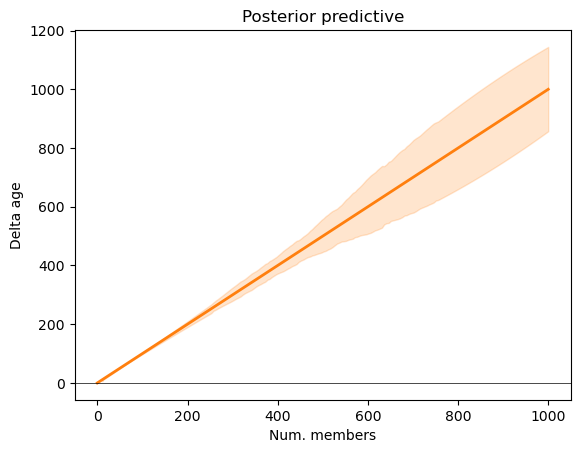

In [196]:
plt.plot(
    x_vals, np.mean(intercept) + np.mean(slope)*x_vals, # + np.mean(quad_slope)*x_vals**2,
    c='tab:orange', lw=2
)
az.plot_hdi(
    x, 
    idata.posterior_predictive["likelihood"], 
    hdi_prob=0.68, smooth_kwargs={'window_length': 100}, color="tab:orange", fill_kwargs={"alpha": .2}
)

# plt.errorbar(x, y_est, yerr=yerr, marker='o', fmt='.', c='k', alpha=1)

# plt.ylim(0, 14)
plt.axhline(0, c='k', lw=0.5)
# plt.scatter(x, y, s=5, c='k', alpha=1);
plt.xlabel('Num. members')
plt.ylabel('Delta age')
plt.title('Posterior predictive')